# Denpasar Weather Forecasting with TensorFlow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## The weather dataset

Data collected between 2009-2016 every 10 minutes

In [2]:
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all']
df = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=['dt_iso'], index_col='dt_iso', usecols=usecols)
df.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
dt_iso,,,,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,98
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,91
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,94
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,94
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,76


In [99]:
df.shape

(264924, 8)

**Functions**

In [106]:
def num_data_train(percentage, data_length):
    num_data = percentage / 100 * data_length
    return int(num_data)

def create_time_steps(length):
    return list(range(-length, 0))

# create a function that return the time windows for the model to train on
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

def multi_step_plot(history, true_future, prediction):
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
def plot_train_history(history, loss_metric_1, loss_metric_2, title):
    lm1 = history.history[loss_metric_1]
    lm2 = history.history[loss_metric_2]
    
    epochs = range(EPOCHS)
    
    plt.figure()
    
    plt.plot(epochs, lm1, 'b', label=loss_metric_1)
    plt.plot(epochs, lm2, 'r', label=loss_metric_2)
    plt.xlabel('Epoch')
    plt.title(title)
    plt.legend()
    plt.show()
    
# Function to resampling time series data
def data_resample(data, time):
    """
    data: Dataframe
    time: Resampling frequencies
    """
    if time == 'hourly':
        df_resample = data.resample('H').mean() # hour
    elif time == 'daily':
        df_resample = data.resample('D').mean() # day
    elif time == 'weekly':
        df_resample = data.resample('W').mean() # week
    elif time == 'monthly':
        df_resample = data.resample('M').mean() # month
    elif time == 'quarterly':
        df_resample = data.resample('Q').mean() # quarter
    elif time == 'yearly':
        df_resample = data.resample('A').mean() # year
    
    return df_resample


from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)

from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print('Results of KPSS Test:')
    kpss_test = kpss(timeseries, regression='c', nlags='legacy') # nlags = 'auto' or 'legacy'
    kpss_output = pd.Series(kpss_test[0:3], index=['Test Statistic', 'p-value', 'Lag Used'])
    for key, value in kpss_test[3].items():
        kpss_output['Critical Value (%s)' % key] = value       
    print(kpss_output)
    
def test_stationarity(timeseries, info):
    """
    timeseries: pandas time series
    info: resampling information, (hourly, daily, weekly, monthly, quarterly, yearly)
    """
    
    # Determining rolling statistics
    windowsize = 24
    rolmean = timeseries.rolling(windowsize).mean()
    rolstd = timeseries.rolling(windowsize).mean()
    
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='yellow', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation ' + info)
    plt.show(block=False)
    
    # Perform Dickey-Fuller Test:
    adf_test(timeseries)
    
    print('\n')
    
    # Perform KPSS Test:
    kpss_test(timeseries)

## Forecast a univariate time series

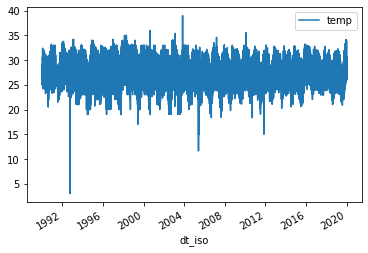

In [102]:
df.loc['1990':'2019'][['temp']].plot()

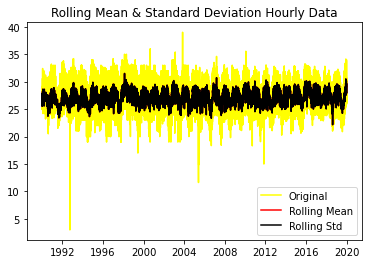

Results of Dickey-Fuller Test:
Test Statistic                    -22.005019
p-value                             0.000000
#Lags Used                         87.000000
Number of Observations Used    264668.000000
Critical Value (1%)                -3.430375
Critical Value (5%)                -2.861551
Critical Value (10%)               -2.566776
dtype: float64


Results of KPSS Test:
Test Statistic           14.532137
p-value                   0.010000
Lag Used                 87.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\rudyh\Documents\Tensorflow-Python\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [107]:
test_stationarity(df.loc['1990':'2019'][['temp']], 'Hourly Data')

In [108]:
# Train a model using a single feature (temperature)
dt_uni = df.loc['1990':'2019'][['temp']]

# Differencing, use this if we want make the data stationary with differencing methods
# dt_uni['diff'] = dt_uni['temp'] - dt_uni['temp'].shift(1)
# dt_uni['diff'] = dt_uni['diff'].fillna(dt_uni['diff'].mean())
# dt_uni = dt_uni['diff'].values

# Transformation, use this if we want make the data stationary with transformation methods
# dt_uni['log'] = np.log(dt_uni['temp'])
# dt_uni['log_diff'] = dt_uni['log'] - dt_uni['log'].shift(1)
# dt_uni['log_diff'] = dt_uni['log_diff'].fillna(dt_uni['log_diff'].mean())
# dt_uni = dt_uni['log_diff']

dt_uni = dt_uni.values
print(dt_uni[:10])

[[25.82]
 [26.2 ]
 [26.45]
 [26.8 ]
 [27.04]
 [27.23]
 [27.32]
 [27.29]
 [27.34]
 [27.23]]


**Split the data**

In [120]:
TRAIN_SPLIT = num_data_train(60, df.shape[0]) # Split 70% of the data for training
print('Length of Data Train: {}'.format(TRAIN_SPLIT))

Length of Data Train: 158954


In [121]:
# Scaling the features
dt_uni_mean = dt_uni[:TRAIN_SPLIT].mean()
dt_uni_std = dt_uni[:TRAIN_SPLIT].std()
print('Training Data Mean: {}'.format(dt_uni_mean))
print('\nTraining Data Std.Dev: {}'.format(dt_uni_std))

Training Data Mean: 27.14024283755048

Training Data Std.Dev: 2.008076492412925


In [122]:
# Standardize the data
dt = (dt_uni - dt_uni_mean) / dt_uni_std

In this part, the model will be given the last **`n`** recorded temperature observation, and needs to learn to predict the temperature at the next **`m`** time step.

In [123]:
# Create the univariate model
past_history = 30 # number of last recorded data (n)
future_target = 5 # number of time step (m)

x_train, y_train = univariate_data(dt, 0, TRAIN_SPLIT, past_history, future_target)
x_val, y_val = univariate_data(dt, TRAIN_SPLIT, None, past_history, future_target)

print('x_train length: {} shape: {}'.format(len(x_train), x_train.shape))
print('y_train length: {} shape: {}'.format(len(y_train), y_train.shape))
print('x_val length: {} shape: {}'.format(len(x_val), x_val.shape))
print('y_val length: {} shape: {}'.format(len(y_val), y_val.shape))

x_train length: 158924 shape: (158924, 30, 1)
y_train length: 158924 shape: (158924, 1)
x_val length: 105767 shape: (105767, 30, 1)
y_val length: 105767 shape: (105767, 1)


In [124]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# Compare with simple LSTM Model, according to several sources LSTM is suitable for modeling time series data
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]), 
        tf.keras.layers.Dense(future_target)
])
model.compile(optimizer='adam', loss='mae')

**Further reading:**
    
    1. https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
    2. https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list/45944225
    3. https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [125]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

datatrain = tf.data.Dataset.from_tensor_slices((x_train, y_train))
datatrain = datatrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataval = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataval = dataval.batch(BATCH_SIZE).repeat()

In [126]:
EPOCHS = 10
STEPS_PER_EPOCH = 200 # number of time steps
VALIDATION_STEPS = 50

# Train the model
model_history = model.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.6086 - val_loss: 0.7645
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6907 - val_loss: 0.4887
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5011 - val_loss: 0.4252
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4555 - val_loss: 0.4383
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5278 - val_loss: 0.4094
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4518 - val_loss: 0.4060
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4245 - val_loss: 0.4114
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5184 - val_loss: 0.4049
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4487 - val_loss: 0.3999
Epoch 10/10
200/200 [==============================] - 2

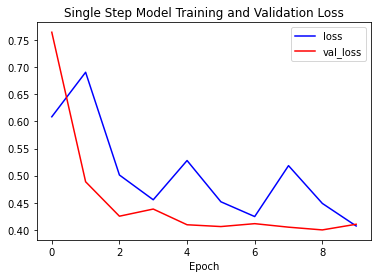

In [127]:
plot_train_history(model_history, 'loss', 'val_loss', 'Single Step Model Training and Validation Loss')
# plot_train_history(model_history, 'mse', 'val_mse', 'Single Step Model Training and Validation Loss')
# plot_train_history(model_history, 'mae', 'val_mae', 'Single Step Model Training and Validation Loss')